# Setup

In [219]:
import os
import json
import sqlite3

import pandas as pd
import numpy as np

# for RNN
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# plot
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [4]:
filepath = 'data/'

In [5]:
data = []
time_df = []

for filename in os.listdir(filepath):
    if 'temp' in filename:
        continue
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    cnx.text_factory = lambda b: b.decode(errors = 'ignore') #https://stackoverflow.com/questions/22751363/sqlite3-operationalerror-could-not-decode-to-utf-8-column
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    start_val = pd.DataFrame({'MEASUREMENT_TIME': df_data.loc[0][0], 'ID_INPUT': 4, 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
    df_data = pd.concat([start_val, df_data])
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))
    
    # get actual start time
    time_diff = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
    utc_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0])
    local_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0])
    time_difference = utc_open - local_open
    
    time_sub = df_data[df_data['ID_INPUT'] == 4].copy()
    time_sub['MEASUREMENT_TIME'] = pd.to_datetime(time_sub['MEASUREMENT_TIME'])
    time_sub['MEASUREMENT_TIME'] = time_sub['MEASUREMENT_TIME'] - time_difference
    time_sub['Time_Used'] = time_sub['MEASUREMENT_TIME'].diff().dt.total_seconds()
    time_sub['Time_Used'] = time_sub['Time_Used'].shift(periods = -1)
    time_sub = time_sub.drop(columns = ['PRIVATE_DATA', 'ID_INPUT'])
    time_df.append(time_sub)

In [4]:
df = pd.concat(data, ignore_index = True)

In [5]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
df['VALUE'] = df['VALUE'].str.lower()

In [6]:
#############
all_time_df = pd.concat(time_df, ignore_index = True)
all_time_df = all_time_df.fillna(0)
all_time_df['Hour'] = all_time_df['MEASUREMENT_TIME'].dt.hour
all_time_df['Date'] = all_time_df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10])
all_time_df['Minute'] = all_time_df['MEASUREMENT_TIME'].dt.minute
all_time_df['Day'] = all_time_df['MEASUREMENT_TIME'].dt.day
all_time_df['Month'] = all_time_df['MEASUREMENT_TIME'].dt.month
all_time_df['Day_Week'] = all_time_df['MEASUREMENT_TIME'].dt.day_name()
all_time_df = all_time_df.assign(Week_Year = all_time_df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%W")))
all_time_df = all_time_df.assign(Week_Day = all_time_df['Week_Year'] + '_' + all_time_df['Day_Week'])

In [7]:
time_per_week_day = all_time_df.copy()
time_per_week_day['Time_Used'] = time_per_week_day['Time_Used'] / 60 / 60
time_per_week_day = time_per_week_day.groupby("Week_Day").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum())
time_per_week_day = pd.DataFrame(time_per_week_day).reset_index(level=1, inplace=False)
df_pivot = time_per_week_day.pivot_table(index = 'Week_Day', columns='VALUE', values='Time_Used').fillna(0)

# Create Features

In [180]:
#############
import datetime
from datetime import timedelta, date

def date_range(start, end):
    dates = []
    delta = end - start
    for i in range(delta.days + 2):
        date = start + timedelta(days=i)
        date = date.strftime("%Y-%m-%d")
        dates.append(date)
    return dates

all_columns = [x for x in range(0,24)]
all_columns.append('Total_Usage')
all_index = date_range(all_time_df['MEASUREMENT_TIME'].min(), all_time_df['MEASUREMENT_TIME'].max())
apps = {}
for app_name in all_time_df['VALUE'].unique():
    if app_name == 's0':
        continue
    app = all_time_df[all_time_df['VALUE'] == app_name]
    #print(app)
    app = app.reset_index()
    zero_data = np.zeros(shape=(len(all_index),len(all_columns)))
    app_df = pd.DataFrame(zero_data, index = all_index, columns = all_columns)
    for x in range(len(app)):
        timestamp = app.loc[x]["MEASUREMENT_TIME"]
        usage = app.loc[x]['Time_Used']
        end_timestamp = timestamp + datetime.timedelta(seconds = usage)
        start_hour = app.loc[x]['Hour']
        end_hour = int(end_timestamp.strftime("%H"))
        date = app.loc[x]['Date']
        if start_hour == end_hour:
            app_df.loc[date][start_hour] += usage
            app_df.loc[date]['Total_Usage'] += usage
        else:
            remaining_seconds = 3600 - (app.loc[x]['Minute'] * 60 + int(timestamp.strftime("%S")))
            app_df.loc[date][start_hour] += remaining_seconds
            app_df.loc[date]['Total_Usage'] += remaining_seconds
            overflow = usage - remaining_seconds
            curr_hour = start_hour + 1
            while overflow > 3600:
                if curr_hour > 23:
                    date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                    date = date.strftime("%Y-%m-%d")
                    curr_hour = 0
                app_df.loc[date][curr_hour] += 3600
                app_df.loc[date]['Total_Usage'] += 3600
                curr_hour = curr_hour + 1
                overflow -= 3600

            if curr_hour > 23:
                date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                date = date.strftime("%Y-%m-%d")
                curr_hour = 0
            app_df.loc[date][curr_hour] += overflow
            app_df.loc[date]['Total_Usage'] += overflow
            
    apps[app_name] = app_df.reset_index(drop = True)

In [181]:
apps['chrome.exe'].head(1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total_Usage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2395.514,599.682,1613.008,0.0,1327.671,3440.171,3354.687,3560.505,3545.317,34029.454


In [182]:
apps['chrome.exe']['date'] = all_time_df['Date'].unique()
apps['chrome.exe'].head(1)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,Total_Usage,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,599.682,1613.008,0.0,1327.671,3440.171,3354.687,3560.505,3545.317,34029.454,2023-01-15


In [11]:
apps['chrome.exe']['Day_Week'] = pd.to_datetime(pd.Series(all_time_df['Date'].unique())).dt.day_name()

In [12]:
apps['chrome.exe'].head(1)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Total_Usage,date,Day_Week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1613.008,0.0,1327.671,3440.171,3354.687,3560.505,3545.317,34029.454,2023-01-15,Sunday


## a). One-hot the day-of-the-week (Mon,...) and sin(hr)

In [235]:
def oh_day_sin_hr(apps, app_name):
    day = 24
    hours_incr = np.arange(24) + 1
    sin_hrs = np.round(np.sin(hours_incr * (np.pi / day)),3)
    
    one_hot_day_encoded = {
        'Monday': [1,0,0,0,0,0,0],
        'Tuesday': [0,1,0,0,0,0,0],
        'Wednesday': [0,0,1,0,0,0,0],
        'Thursday': [0,0,0,1,0,0,0],
        'Friday': [0,0,0,0,1,0,0],
        'Saturday': [0,0,0,0,0,1,0],
        'Sunday': [0,0,0,0,0,0,1]
    }
    apps[app_name]['date'] = all_time_df['Date'].unique()
    apps[app_name]['Day_Week'] = pd.to_datetime(pd.Series(all_time_df['Date'].unique())).dt.day_name()
    apps[app_name]['Day_Week'] = apps[app_name]['Day_Week'].apply(lambda x: one_hot_day_encoded[x])

    vanilla_df = apps[app_name]
    X = []
    y = np.array([])
    for row in vanilla_df.iterrows():
        #print(row[1])
        feats = []
        for hr in sin_hrs:
            feats = feats + [np.append(hr, row[1]['Day_Week'])]
        targets = row[1][:24]
        #print(np.array(feats).shape)
        X = X + feats
        y = np.append(y, np.array(targets))
    
    X = np.array(X)

    return X, y

In [236]:
X, y = oh_day_sin_hr(apps, 'VsDebugConsole.exe')

In [231]:
apps.keys()

dict_keys(['VsDebugConsole.exe', 'explorer.exe', 'devenv.exe', 'ApplicationFrameHost.exe', 'chrome.exe', 'ShellExperienceHost.exe', 'SearchApp.exe', 'Unable To Open Process', 'SnippingTool.exe', 'DB Browser for SQLite.exe', 'Code.exe', 'CodeSetup-stable-97dec172d3256f8ca4bfb2143f3f76b503ca0534.tmp', 'IDMan.exe', 'msedge.exe', 'rstudio.exe', 'mintty.exe', 'Zoom.exe', 'Installer.exe', 'TeamViewer.exe', 'mshta.exe', 'GoogleDriveFS.exe', 'GitHub.UI.exe', 'rundll32.exe', 'OpenWith.exe', 'StartMenuExperienceHost.exe', 'Update.exe', 'GitHubDesktop.exe', 'CodeSetup-stable-e2816fe719a4026ffa1ee0189dc89bdfdbafb164.tmp', 'cmd.exe', 'CodeSetup-stable-441438abd1ac652551dbe4d408dfcec8a499b8bf.tmp'])

## b) Sin(hrs) only

In [202]:
def sin_hr(apps, app_name):
    day = 24
    hours_incr = np.arange(24) + 1
    sin_hrs = np.round(np.sin(hours_incr * (np.pi / day)),3)

    vanilla_df = apps[app_name]
    X = []
    y = np.array([])
    for row in vanilla_df.iterrows():
        #print(row[1])
        feats = []
        for hr in sin_hrs:
            feats = feats + [hr]
        targets = row[1][:24]
        #print(np.array(feats).shape)
        X = X + feats
        y = np.append(y, np.array(targets))
    
    X = np.array(X)

    return X, y

In [203]:
X, y = sin_hr(apps, 'chrome.exe')

## Try the features on the model

In [204]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [286]:
def prep_data(batch_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2/(1-0.2), shuffle=False)
    X_train, X_val, X_test, y_train, y_val, y_test = X_train, X_val, X_test, np.array(y_train).reshape(-1,1), np.array(y_val).reshape(-1,1), np.array(y_test).reshape(-1,1)

    scaler = MinMaxScaler() 
    y_train_scaled = scaler.fit_transform(y_train)
    y_val_scaled = scaler.fit_transform(y_val)
    y_test_scaled = scaler.fit_transform(y_test)

    # Data into tensor
    train_X = torch.Tensor(X_train)
    train_y = torch.Tensor(y_train_scaled)
    #train_y = torch.Tensor(np.array(y_train, dtype=float))

    val_X = torch.Tensor(X_val)
    val_y = torch.Tensor(y_val_scaled)
    #val_y = torch.Tensor(np.array(y_val, dtype=float))

    test_X = torch.Tensor(X_test)
    test_y = torch.Tensor(y_test_scaled)
    #test_y = torch.Tensor(np.array(y_test_scaled, dtype=float))

    train = TensorDataset(train_X, train_y)
    val = TensorDataset(val_X, val_y)
    test = TensorDataset(test_X, test_y)
        
    batch_size = 1
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

    print(len(train_loader.dataset))
    print(len(val_loader.dataset))
    print(len(test_loader.dataset))
    print(len(test_loader_one.dataset))

    return train_loader, val_loader, test_loader, test_loader_one


In [287]:
train_loader, val_loader, test_loader, test_loader_one = prep_data(15)

446
149
149
149


## Dumpster 1

In [50]:
class simpleRNN(nn.Module):
    def __init__(self, in_dims, hidden_size, out_dims):
        super(simpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in_to_hidden = nn.Linear()
        self.in

In [104]:
import torch.nn as nn
import torch.nn.functional as F

In [121]:
class simpleRNN(nn.Module):
    def __init__(self, input_dims, hidden_dims, num_layers):
        super(simpleRNN, self).__init__()
        self.simpleRNN = nn.RNN(input_dims, hidden_dims, num_layers)
        
    def forward(self, x):
        return self.simpleRNN(x)

In [107]:
input_size = 8
hidden_size = 5
batch_size = 15
num_layers = 1
learning_rate = 0.001
num_iter = 50 

model = simpleRNN(input_size, hidden_size, num_layers)

In [120]:
output, hidden_layer = model(train_X)

RuntimeError: input must have 3 dimensions, got 2

In [116]:
train_X.shape

torch.Size([178, 8])

In [103]:

# average training loss,
# one value per iteration (averaged over all batches in one iteration)
avg_train_loss = []
# average validation loss, 
# one value per iteration (averaged over all batches in one iteration)
avg_val_loss = []
# record the lowest validation loss, 
# used to determine early stopping (best model)
best_val_score = float('inf')
net = simpleRNN(input_size, hidden_size)
# TODO4: define loss function
#       define optimizer
#       for each iteration, iteratively train all batches
loss_function = torch.nn.CrossEntropyLoss()
#optimizer = SGD(net.parameters(), lr=learning_rate) # for Q5a
optimizer = torch.optim.Adam(list(net.parameters()), lr=learning_rate) # for Q5b

i = 0
count = 0 # early stopping counter
while i < num_iter:
    # TODO5: implement your training and early stopping
    train_loss = []
    val_loss = []
    for _, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(X)
        print(output)
        loss = loss_function(output, y.long())
        # calculate loss gradient
        loss.backward()
        # update weights
        optimizer.step()
        # append loss
        train_loss.append(loss)
        #print('train loss =', train_loss)
    avg_train_loss.append(torch.mean(torch.tensor(train_loss)))
    
    for _, (X,y) in enumerate(val_loader):
        output = net(X)
        loss = loss_function(output, y.long()) #logistic_loss((X,y), net)
        val_loss.append(loss)
    avg_val = torch.mean(torch.tensor(val_loss))
    avg_val_loss.append(avg_val)
    # TODO6: save the best model with lowest validation loss and load it to do testing
    if avg_val < best_val_score:
        best_val_score = avg_val
        #print('here')
        #torch.save(net.state_dict(),"checkpoint.pt")
        count = 0
    else:
        count += 1
    if count == 5:
        break
    i += 1
#net = simpleRNN()
#net.load_state_dict(torch.load("checkpoint.pt"))

torch.Size([15, 5])
tensor([[0.1611, 0.1577, 0.2954, 0.2022, 0.1837],
        [0.1550, 0.1613, 0.3001, 0.1953, 0.1882],
        [0.1492, 0.1650, 0.3044, 0.1888, 0.1926],
        [0.1440, 0.1685, 0.3079, 0.1828, 0.1968],
        [0.1392, 0.1719, 0.3109, 0.1773, 0.2007],
        [0.1351, 0.1750, 0.3133, 0.1725, 0.2042],
        [0.1315, 0.1777, 0.3152, 0.1683, 0.2073],
        [0.1286, 0.1801, 0.3166, 0.1649, 0.2099],
        [0.1263, 0.1820, 0.3176, 0.1622, 0.2119],
        [0.1247, 0.1834, 0.3183, 0.1602, 0.2134],
        [0.1237, 0.1842, 0.3187, 0.1591, 0.2142],
        [0.1234, 0.1845, 0.3189, 0.1587, 0.2146],
        [0.1237, 0.1842, 0.3187, 0.1591, 0.2142],
        [0.1247, 0.1834, 0.3183, 0.1602, 0.2134],
        [0.1263, 0.1820, 0.3176, 0.1622, 0.2119]], grad_fn=<SoftmaxBackward>)


RuntimeError: 1D target tensor expected, multi-target not supported

In [1]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## Dumpster 2

In [75]:
import torch.nn.functional as F
import torch.nn as nn

In [82]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        #combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(x))
        output = self.in2output(hidden)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [67]:
hidden_size = 5
learning_rate = 0.001

model = MyRNN(8, hidden_size, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    for i, (name, label) in enumerate(train_loader):
        hidden_state = F.softmax(model.init_hidden(), dim=1).view(-1)
        for char in name:
            #print(char)
            print(hidden_state)
            #print(hidden_state.size())
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_loader)}], "
                f"Loss: {loss.item():.4f}"
            )

tensor([0.3331, 0.3486, 0.0727, 0.1045, 0.1412])
tensor([0.4761, 0.5173, 0.4744, 0.5087, 0.6027], grad_fn=<SigmoidBackward>)
tensor([0.5079, 0.5627, 0.4546, 0.5444, 0.6583], grad_fn=<SigmoidBackward>)
tensor([0.5100, 0.5713, 0.4519, 0.5511, 0.6674], grad_fn=<SigmoidBackward>)
tensor([0.5101, 0.5731, 0.4528, 0.5542, 0.6727], grad_fn=<SigmoidBackward>)
tensor([0.5103, 0.5743, 0.4539, 0.5569, 0.6773], grad_fn=<SigmoidBackward>)
tensor([0.5105, 0.5753, 0.4550, 0.5593, 0.6815], grad_fn=<SigmoidBackward>)
tensor([0.5107, 0.5763, 0.4560, 0.5614, 0.6852], grad_fn=<SigmoidBackward>)
tensor([0.5108, 0.5770, 0.4568, 0.5632, 0.6883], grad_fn=<SigmoidBackward>)
tensor([0.5110, 0.5777, 0.4574, 0.5647, 0.6907], grad_fn=<SigmoidBackward>)
tensor([0.5111, 0.5782, 0.4578, 0.5657, 0.6925], grad_fn=<SigmoidBackward>)
tensor([0.5112, 0.5785, 0.4581, 0.5664, 0.6936], grad_fn=<SigmoidBackward>)
tensor([0.5112, 0.5786, 0.4582, 0.5666, 0.6940], grad_fn=<SigmoidBackward>)
tensor([0.5112, 0.5786, 0.4580, 0.5665,

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Dumpster 3

In [223]:
# Model implementation
# Vanilla RNN
from torch import nn
class VanillaRNN(nn.Module):
    def __init__(self, input_dims, num_nodes, num_layers, output_dims, dropout_prob):
        super(VanillaRNN, self).__init__()

        self.num_nodes = num_nodes
        self.num_layers = num_layers
        
        self.vanilla_rnn = nn.RNN(input_dims, num_nodes, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(num_nodes, output_dims) # fully connected layer
        #print('after fc')
    
    def forward(self, x):
        hidden_0 = torch.zeros(self.num_layers, x.size(0), self.num_nodes).requires_grad_()
        
        forward_out, hidden_0 = self.vanilla_rnn(x, hidden_0.detach()) # forward propagation
        
        forward_out = forward_out[:, -1, :] # reshape the output for the fc
        out = self.fc(forward_out)
        
        return out


In [224]:
class Optimization:
    def __init__(self, model, loss_func, optimizer):
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.train_losses = np.array([])
        self.val_losses = np.array([])
    
    def train_step(self, x, y):
        #print('train step ', x)
        self.model.train()
        yhat = self.model(x) # preds
        loss = self.loss_func(y, yhat)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=7, n_epochs=50, n_feats=1):
        val_values = np.array([])
        val_preds = np.array([])

        for epoch in range(n_epochs):
            batch_losses = np.array([])
            #print(epoch)
            for x_batch, y_batch in train_loader:
                #print('train ', x_batch)
                x_batch = x_batch.view([batch_size, -1, n_feats]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses = np.append(batch_losses, loss)
            train_loss = np.mean(batch_losses)
            self.train_losses = np.append(self.train_losses, train_loss)

            with torch.no_grad():
                batch_val_losses = np.array([])
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_feats]).to(device)
                    y_val = y_val.to(device)

                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_func(y_val, yhat).item()
                    batch_val_losses = np.append(batch_val_losses, val_loss)
                    
                val_loss = np.mean(batch_val_losses)
                self.val_losses = np.append(self.val_losses, val_loss)

                
            if (epoch <= 10) | (epoch % 50 == 0):
                print(f'Training loss: {train_loss}, val loss {val_loss}')   
        
        val_values = np.append(val_values, y_val.to(device).detach().numpy())
        val_preds = np.append(val_preds, yhat.to(device).detach().numpy())  
        
        return val_values, val_preds
    
    def evaluate(self, test_loader, batch_size=1, n_feats=1):
        with torch.no_grad():
            test_preds = np.array([])
            test_vals = np.array([])

            for x_test, y_test in test_loader.dataset:
                x_test = x_test.view([batch_size, -1, n_feats]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)

                test_vals = np.append(test_vals, y_test.to(device).detach().numpy())
                test_preds = np.append(test_preds, yhat.to(device).detach().numpy())

        return test_vals, test_preds
    

    def plot_losses(self):
        plt.plot(self.train_losses, label="train loss")
        plt.plot(self.val_losses, label='Val loss')
        plt.legend()
        plt.title('losses')
        plt.show()
        plt.close()

In [290]:
input_dims = 8
num_layers = 5
num_nodes = 5
output_dims = 1
batch_size = 1
n_epochs = 150
dropout = 0.1
lr = 1e-3
model_params = {
    'input_dims': input_dims,
    'num_nodes': num_nodes,
    'num_layers': num_layers,
    'output_dims': output_dims,
    'dropout_prob': dropout
}

c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:93: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training loss: 0.02749914878451019, val loss 0.05075409888421129
Training loss: 0.014311034805579905, val loss 0.04688009569708933
Training loss: 0.011131797649901812, val loss 0.04512728175660908
Training loss: 0.009021746109536277, val loss 0.046359490828226074
Training loss: 0.00840583720689247, val loss 0.04547200536967924
Training loss: 0.008102528121836082, val loss 0.04626387992761279
Training loss: 0.00864731187717112, val loss 0.04518574586250638
Training loss: 0.008018946646808776, val loss 0.045299671790343804
Training loss: 0.008189290643444144, val loss 0.04632596466565292
Training loss: 0.007944235893492607, val loss 0.045302414254054124
Training loss: 0.008094820896614627, val loss 0.04531731741540384
Training loss: 0.007651486275341746, val loss 0.04515059762353065
Training loss: 0.00790987548892357, val loss 0.0473318172981275


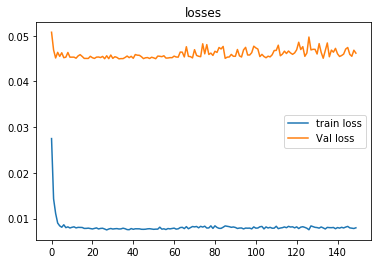

In [291]:
from torch import optim
import random
model = VanillaRNN(**model_params)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
opt = Optimization(model=model, loss_func=loss_func, optimizer=optimizer)
val_values_vanilla, val_preds_vanilla = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_feats=input_dims)
opt.plot_losses()

In [292]:
def output():
    test_values_vanilla, test_preds_vanilla = opt.evaluate(test_loader_one, batch_size=batch_size, n_feats=input_dims)
    
    out = pd.DataFrame({
        'test_val': test_values_vanilla,
        'test_pred': test_preds_vanilla
    })

    sns.lineplot(data=out)

    return out

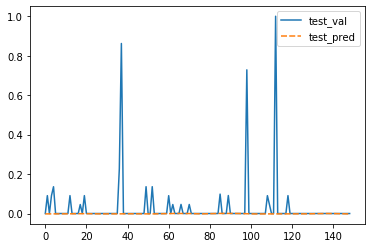

In [293]:
out = output()

In [294]:
out['test_pred'][:]

0     -0.001906
1     -0.001941
2     -0.001966
3     -0.001983
4     -0.001996
         ...   
144   -0.001425
145   -0.001633
146   -0.001770
147   -0.001856
148   -0.001911
Name: test_pred, Length: 149, dtype: float64

## Dumpster 4

In [310]:
sequence_length = 1
num_classes = 1
input_size = 8

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return torch.sigmoid(out)

model = RNN(input_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, batch_size, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        #print(labels[0])
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
test_output = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, batch_size, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        test_output = test_output + [predicted]
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test data: {acc} %')

Epoch [1/2], Step [100/446], Loss: 0.3194
Epoch [1/2], Step [200/446], Loss: 0.1645
Epoch [1/2], Step [300/446], Loss: 0.0998
Epoch [1/2], Step [400/446], Loss: 0.1492
Epoch [2/2], Step [100/446], Loss: 0.0513
Epoch [2/2], Step [200/446], Loss: 0.0405
Epoch [2/2], Step [300/446], Loss: 0.0329
Epoch [2/2], Step [400/446], Loss: 0.1335
Accuracy of the network on the test data: 85.90604026845638 %


In [311]:
test_output

[tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tenso